In [1]:
import os
import numpy as np
from scipy.interpolate import griddata
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# Répertoires fichiers grilles
rep = '/home/thibault-delahaye/git_dev/notebook-grid-tools/DATASETS_CROCOTOOLS/Topo/to_merge_ter/'

# Chemins des rasters à fusionner
input1 = rep + "MNT_NC100m_TSUCAL_GEO_refNM_ZNEG_V1.0.grd" # HIGH RESOLUTION
#input2 = rep + "gebco_2024_n-14.502_s-25.4004_w158.5986_e171.6064.nc" #LOW RESOLUTION
input2= rep + "etopo_2022_NC.tiff"
#OUTPUT de la fusion
#output = rep + "gebco_x_tsucal"

In [3]:
# Ouvrir le fichier 1
ds1 = xr.open_dataset(input1)

# Ouvrir le fichier 2
#try:
#    import rioxarray
#    ds2_dataArray= rioxarray.open_rasterio(input2)
    # Transformer le DataArray en Dataset
#    ds2_temp = ds2_dataArray.to_dataset()
#    ds2= ds2_temp.sel(band=1, drop=True)
#except:
ds2 = xr.open_dataset(input2)

In [4]:
if input2[-4:]=='tiff':
    ds2= ds2.sel(band=1, drop=True)

In [5]:
# Identifier la variable contenant les données de bathymétrie
# On suppose que la variable de bathymétrie est la seule avec des valeurs numériques

for var_name in ds1.data_vars:
    var_data = ds1[var_name]
    # Vérifier si la variable est 2D et contient des valeurs numériques
    if var_data.ndim == 2 and var_data.dtype.kind in {'f', 'i'}:
         z_ds1= var_name
         break
else:
    print("Aucune variable de bathymétrie trouvée dans ds1")

for var_name in ds2.data_vars:
    var_data = ds2[var_name]
    # Vérifier si la variable est 2D et contient des valeurs numériques
    if var_data.ndim == 2 and var_data.dtype.kind in {'f', 'i'}:
         z_ds2= var_name
         break
else:
    print("Aucune variable de bathymétrie trouvée dans ds2")

In [6]:
# Identifier les noms des coordonnées lat/lon des fichiers

for coord_name in ds1.coords:
    coord_data = ds1[coord_name]
    # On suppose que lon et lat sont généralement des coordonnées avec des valeurs géographiques
    if coord_name.lower() in {'lon', 'longitude'}:
        lon_coord_ds1  = coord_name
    elif coord_name.lower() in {'lat', 'latitude'}:
        lat_coord_ds1  = coord_name
    elif coord_data.dims == ('x',) or coord_data.dims == ('y',):
        if 'x' in coord_data.dims:
            lon_coord_ds1 = coord_name
        if 'y' in coord_data.dims:
            lat_coord_ds1 = coord_name

for coord_name in ds2.coords:
    coord_data = ds2[coord_name]
    # On suppose que lon et lat sont généralement des coordonnées avec des valeurs géographiques
    if coord_name.lower() in {'lon', 'longitude'}:
        lon_coord_ds2  = coord_name
    elif coord_name.lower() in {'lat', 'latitude'}:
        lat_coord_ds2  = coord_name
    elif coord_data.dims == ('x',) or coord_data.dims == ('y',):
        if 'x' in coord_data.dims:
            lon_coord_ds2 = coord_name
        if 'y' in coord_data.dims:
            lat_coord_ds2 = coord_name

In [7]:
#Interpoler la grille de basse résolution sur une grille de résolution = HIGH RES

#Déterminer la résolution de la grille 1
resolution_lon= np.diff(ds1[lon_coord_ds1]).mean()
resolution_lat= np.diff(ds1[lat_coord_ds1]).mean()

lon2= ds2[lon_coord_ds2].values
lat2= ds2[lat_coord_ds2].values
z2= ds2[z_ds2].values

# Récupérér grille ds2 initiale
lon_grid_2, lat_grid_2 = np.meshgrid(lon2, lat2)

In [8]:
# Aplatir les grilles 2D et les valeurs
lon_flat_2 = lon_grid_2.ravel()
lat_flat_2 = lat_grid_2.ravel()
z_flat_2 = z2.ravel()

# Créer une nouvelle grille ds2
new_lon_2 = np.arange(lon2.min(), lon2.max(), resolution_lon)
new_lat_2 = np.arange(lat2.min(), lat2.max(), resolution_lat)
new_lon_grid_2, new_lat_grid_2 = np.meshgrid(new_lon_2, new_lat_2)

In [9]:
z2_interp = griddata((lon_flat_2, lat_flat_2), z_flat_2, (new_lon_grid_2, new_lat_grid_2), method='nearest')

In [10]:
lon1= ds1[lon_coord_ds1].values
lat1= ds1[lat_coord_ds1].values
z1= ds1[z_ds1].values

# Récupérér grille ds2 initiale
lon_grid_1, lat_grid_1 = np.meshgrid(lon1, lat1)

# Aplatir les grilles 2D et les valeurs
lon_flat_1 = lon_grid_1.ravel()
lat_flat_1 = lat_grid_1.ravel()
z_flat_1 = z1.ravel()

# 1. Identifier la zone de chevauchement entre les grilles
lon_min_1, lon_max_1 = lon1.min(), lon1.max()  # Étendue de la grille 1 en longitude
lat_min_1, lat_max_1 = lat1.min(), lat1.max()  # Étendue de la grille 1 en latitude

# Créer un masque sur la grille rééchantillonnée de la grille 2 qui couvre seulement la zone de la grille 1
mask_overlap = (new_lon_grid_2 >= lon_min_1) & (new_lon_grid_2 <= lon_max_1) & \
               (new_lat_grid_2 >= lat_min_1) & (new_lat_grid_2 <= lat_max_1)

# 2. Interpolation des données de la grille 1 (haute résolution) uniquement sur la zone couverte par la grille 1
z1_interp_on_z2_overlap = griddata(
    (lon_flat_1, lat_flat_1),  # Points d'origine (grille 1)
    z_flat_1,                  # Valeurs d'origine (grille 1)
    (new_lon_grid_2[mask_overlap], new_lat_grid_2[mask_overlap]),  # Points cibles (zone de la grille 1 dans la grille 2)
    method='nearest'           # Méthode d'interpolation
)


In [11]:
z2_save= z2_interp.copy()

# 3. Remplacer les données de z2_interp uniquement dans la zone de chevauchement avec celles de la grille 1
z2_interp[mask_overlap] = z1_interp_on_z2_overlap

### LISSAGE

In [12]:
# Définir la largeur de la zone tampon en nombre de mailles
buffer_width = 30


#Bords de la grille haute résolution dans la grille finale
lon_min= new_lon_grid_2[mask_overlap].min()
lon_max= new_lon_grid_2[mask_overlap].max()
lat_min= new_lat_grid_2[mask_overlap].min()
lat_max= new_lat_grid_2[mask_overlap].max()

# Calculer les limites extérieures de la zone tampon
lon_buffer_min = lon_min - buffer_width * resolution_lon
lon_buffer_max = lon_max + buffer_width * resolution_lon
lat_buffer_min = lat_min - buffer_width * resolution_lat
lat_buffer_max = lat_max + buffer_width * resolution_lat

#Masque: zone tampon + grille haute résolution
mask_buff_extremum=(new_lon_grid_2 >= lon_buffer_min) & (new_lon_grid_2 <= lon_buffer_max) & \
                   (new_lat_grid_2 >= lat_buffer_min) & (new_lat_grid_2 <= lat_buffer_max)

# Zone tampon excluant la grille haute résolution
mask_buffer= mask_buff_extremum & ~mask_overlap

### Lissage des nan

In [80]:
mask_nan = np.isnan(z2_interp) & ~np.isnan(z2_save)
z2_combined= z2_interp.copy()
#z2_combined[mask_nan]= z2_save[mask_nan]

In [14]:
#from scipy.interpolate import RectBivariateSpline
# Créer un interpolateur avec les nouvelles coordonnées
#spline = RectBivariateSpline(new_lat_grid_2[:, 0], new_lon_grid_2[0, :],z2_combined, s=10)

# Interpoler sur les nouvelles coordonnées
#z2_smoothed = spline(new_lat_grid_2[:, 0], new_lon_grid_2[0, :])

###
#z2_interp[mask_nan]= z2_smoothed[mask_nan]

In [98]:
#mask_nan = np.isnan(z2_interp) & ~np.isnan(z2_save)
#z2_combined= z2_interp.copy()

from scipy.ndimage import binary_erosion, binary_dilation
# Créer un élément structurant de taille 10x10
structure = np.ones((10, 10), dtype=bool)  # Élément structurant de 10x10

# Appliquer l'érosion binaire avec cet élément structurant
mask_eroded = binary_erosion(mask_nan, structure=structure) #.astype(int)

# Appliquer la dilatation binaire au mask_eroded
mask_dilated = binary_dilation(mask_eroded, structure=structure)

# Soustraire le mask_eroded au mask dilaté pour récupérer la zone tampon
mask_transition = mask_dilated & ~mask_eroded

mask_interpolation= mask_nan & ~mask_dilated

In [99]:
transition_dilated = binary_dilation(mask_transition, structure=np.ones((3, 3)))
transition_borders= transition_dilated & ~mask_transition

In [101]:
z2_combined[mask_eroded]= z2_save[mask_eroded] #les données dans la zone érodée sont les données low res brutes

In [102]:
from scipy.spatial import cKDTree
coords_mask_transition = np.array(np.where(mask_transition)).T
coords_transition_borders_int = np.array(np.where(transition_borders & mask_eroded)).T
coords_transition_borders_ext = np.array(np.where(transition_borders & ~mask_eroded)).T

In [103]:
# Construire un KDTree avec les coordonnées des bords
tree_transition_borders_int = cKDTree(coords_transition_borders_int)

# Calculer les distances minimales des mailles du masque vers les bords
distances_int, indices_int = tree_transition_borders_int.query(coords_mask_transition)

In [104]:
tree_transition_borders_ext = cKDTree(coords_transition_borders_ext)

# Calculer les distances minimales des mailles du masque vers les bords
distances_ext, indices_ext = tree_transition_borders_ext.query(coords_mask_transition)

In [20]:
#z2_combined[mask_nan]= z2_save[mask_nan] #tous les trous sont déosmrais des low res data

In [109]:
def get_values_from_indices(indices, coords_borders):
    values = np.full(len(indices), np.nan)
    for i, idx in enumerate(indices):
        if idx < len(coords_borders):
            x, y = coords_borders[idx]
            values[i] = z2_combined[x, y]
    return values
    
values_int = get_values_from_indices(indices_int, coords_transition_borders_int)
values_ext = get_values_from_indices(indices_ext, coords_transition_borders_ext)

In [112]:
tot_dist= distances_int + distances_ext
weight_out= distances_int/tot_dist
weight_in= distances_ext/tot_dist
ponderated_transition= weight_in * values_int + weight_out * values_ext

In [119]:
def apply_ponderated_values(z2_combined, mask_transition, ponderated_values, coords_mask_transition):
    for i, (coord, value) in enumerate(zip(coords_mask_transition, ponderated_values)):
        x, y = coord
        if mask_transition[x, y]:
            z2_combined[x, y] = value
    return z2_combined

# Appliquer les valeurs pondérées
z2_combined = apply_ponderated_values(z2_combined, mask_transition, ponderated_transition, coords_mask_transition)

In [26]:
# Coordonnées des points connus
#known_points = np.array(np.nonzero(~mask_interpolation)).T
#known_values = z2_combined[~mask_interpolation]

# Coordonnées des points inconnus (NaN)
#unknown_points = np.array(np.nonzero(mask_interpolation)).T

# Interpolation
#z2_interpolated = griddata(known_points, known_values, unknown_points, method='linear', fill_value=np.nan)


In [27]:
# Remplacer les NaN dans z2_combined
#z2_combined[mask_nan] = z2_interpolated

In [139]:
nan_end=np.isnan(z2_combined)

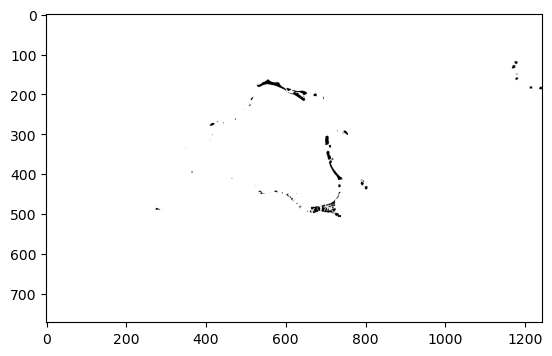

In [145]:
plt.imshow(nan_end[x_start:x_end, y_start:y_end], cmap='Greys')

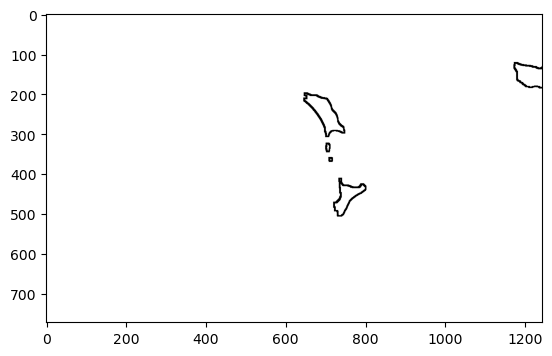

In [144]:
plt.imshow(mask_transition[x_start:x_end, y_start:y_end], cmap='Greys')

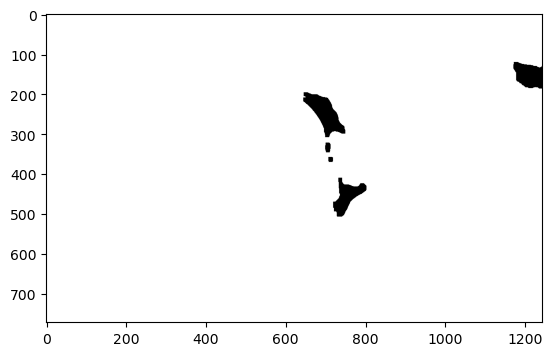

In [148]:
plt.imshow(mask_dilated[x_start:x_end, y_start:y_end], cmap='Greys')

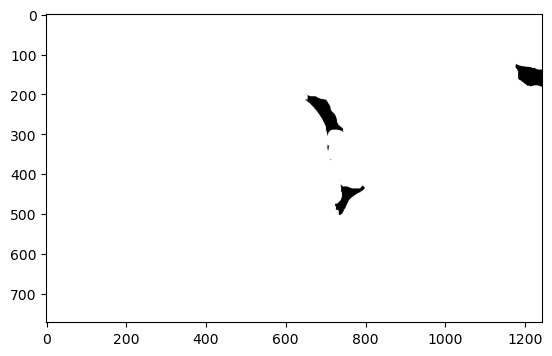

In [147]:
plt.imshow(mask_eroded[x_start:x_end, y_start:y_end], cmap='Greys')

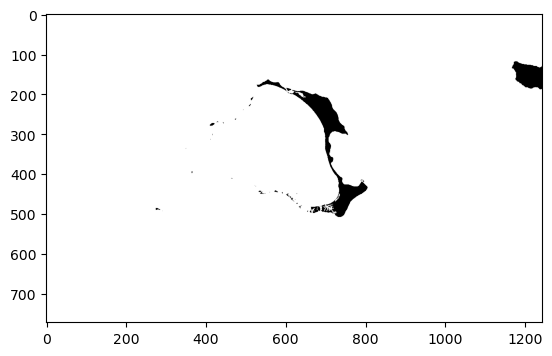

In [146]:
plt.imshow(mask_nan[x_start:x_end, y_start:y_end], cmap='Greys')

In [1]:
z2_interp

NameError: name 'z2_interp' is not defined

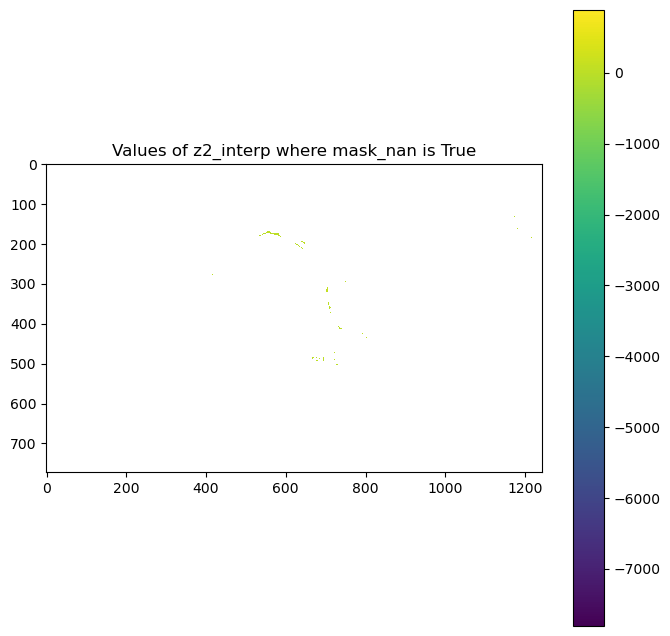

In [155]:
display_array = np.full(z2_save.shape, np.nan)
display_array[nan_end] = z2_save[nan_end]

# Affichage
plt.figure(figsize=(8, 8))
plt.title('Values of z2_interp where mask_nan is True')
plt.imshow(display_array[x_start:x_end, y_start:y_end], cmap='viridis', vmin=np.nanmin(z2_interp), vmax=np.nanmax(z2_interp))
plt.colorbar()
plt.show()


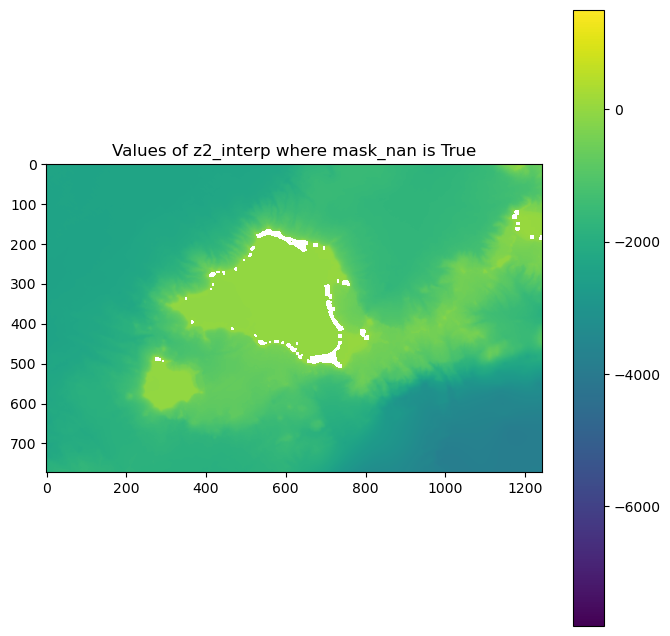

In [156]:
# Affichage
plt.figure(figsize=(8, 8))
plt.title('Values of z2_interp where mask_nan is True')
plt.imshow(z2_combined[x_start:x_end, y_start:y_end], cmap='viridis', vmin=np.nanmin(z2_combined), vmax=np.nanmax(z2_combined))
plt.colorbar()
plt.show()

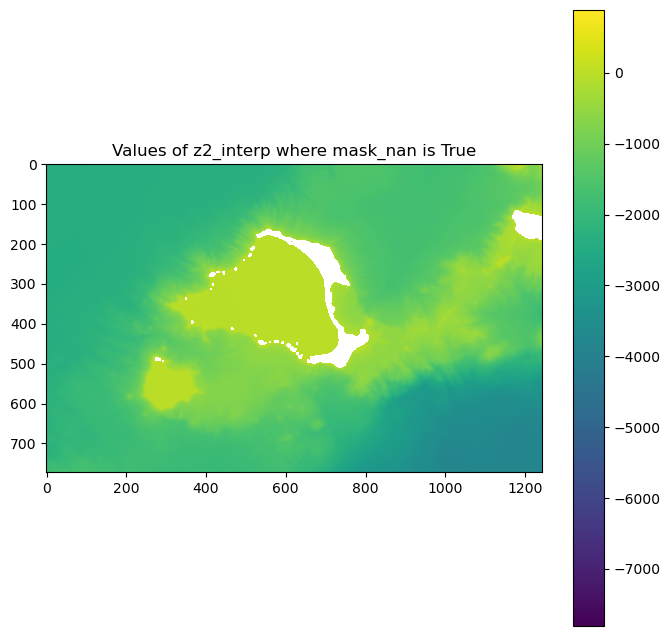

In [157]:
# Affichage
plt.figure(figsize=(8, 8))
plt.title('Values of z2_interp where mask_nan is True')
plt.imshow(z2_interp[x_start:x_end, y_start:y_end], cmap='viridis', vmin=np.nanmin(z2_interp), vmax=np.nanmax(z2_interp))
plt.colorbar()
plt.show()

In [ ]:
# Identifier les positions des NaN
nan_positions = np.isnan(z2_combined)
non_nan_positions = ~nan_positions

# Créer des coordonnées pour l'interpolation
x, y = np.indices(z2_combined.shape)

# Extraire les positions des NaN et non-NaN
points = np.vstack((x[non_nan_positions], y[non_nan_positions])).T
values = z2_combined[non_nan_positions]

# Points à interpoler
interp_points = np.vstack((x[nan_positions], y[nan_positions])).T

# Interpolation
interpolated_values_nan = scipy.interpolate.griddata(points, values, interp_points, method='linear')


In [33]:
#### TEST
from scipy import ndimage
import matplotlib.pyplot as plt

def compute_nan_clusters_diameters(matrix):
    # Créer un masque binaire pour les NaN
    nan_mask = np.isnan(matrix)
    
    # Identifier les régions contiguës de NaN
    labeled_array, num_features = ndimage.label(nan_mask)
    
    # Calculer les propriétés des régions
    cluster_diameters = []
    
    # Pour chaque région identifiée
    for region_id in range(1, num_features + 1):
        # Trouver les coordonnées des éléments de la région
        region_coords = np.array(np.nonzero(labeled_array == region_id))
        
        # Calculer les coordonnées minimales et maximales dans chaque dimension
        min_coords = np.min(region_coords, axis=1)
        max_coords = np.max(region_coords, axis=1)
        
        # Calculer les dimensions de la région
        region_dims = max_coords - min_coords
        
        # Calculer le diamètre (distance maximale entre les points)
        # Utilisation de la distance euclidienne pour les extrémités
        diameter = np.sqrt(np.sum(np.square(region_dims)))
        cluster_diameters.append(diameter)
    
    return cluster_diameters, labeled_array

In [35]:
diameters, labeled_array = compute_nan_clusters_diameters(z2_combined_updated)
print("Diamètres des agglomérats de NaN :", diameters)


Diamètres des agglomérats de NaN : [0.0, 13.416407864998739, 1.0, 30.364452901377952, 31.953090617340916, 21.2602916254693, 0.0, 0.0, 0.0, 5.830951894845301, 3.0, 0.0, 9.219544457292887, 5.0, 0.0, 0.0, 2.0, 1.0, 5.0990195135927845, 2.8284271247461903, 3.605551275463989, 5.0, 8.06225774829855, 9.219544457292887, 19.209372712298546, 9.848857801796104, 0.0, 4.47213595499958, 8.54400374531753, 2.0, 2.23606797749979, 0.0, 0.0, 1.0, 5.830951894845301, 1.4142135623730951, 5.656854249492381, 10.816653826391969, 9.219544457292887, 2.0, 2.23606797749979, 0.0, 2.0, 3.605551275463989, 32.2490309931942, 9.219544457292887, 0.0, 0.0, 0.0, 1.0, 3.1622776601683795, 15.620499351813308, 0.0, 2.0, 3.0, 1.4142135623730951, 7.211102550927978, 0.0, 1.0, 8.06225774829855, 1.4142135623730951, 0.0, 1.0, 0.0, 1.0, 11.40175425099138, 4.242640687119285, 0.0, 11.180339887498949, 7.0710678118654755, 0.0, 3.605551275463989, 1.4142135623730951, 5.0, 0.0, 1.4142135623730951, 6.4031242374328485, 0.0, 5.0, 0.0, 2.8284271

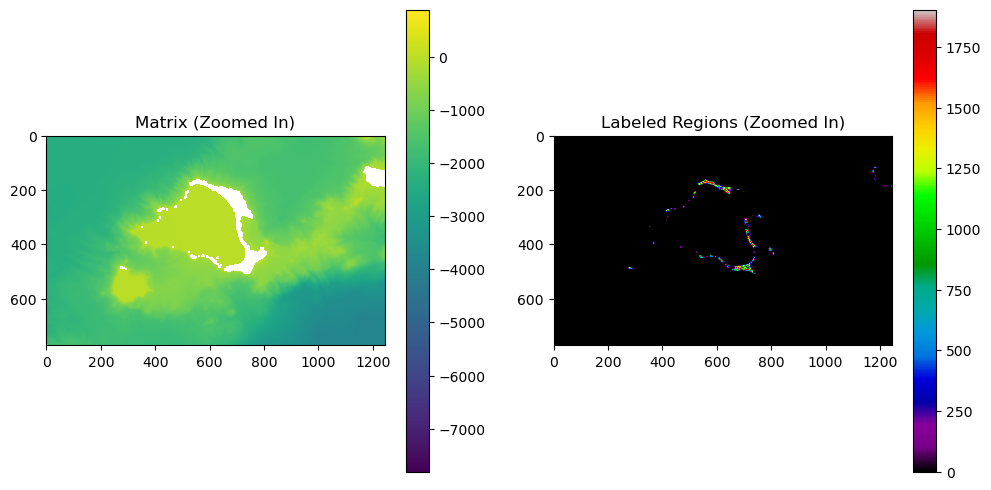

In [58]:
matrix= z2_interp

# Dimensions de la matrice
N, M = matrix.shape

# Facteur de zoom
zoom_factor = 10

# Dimensions de la région zoomée
zoomed_width = M // zoom_factor
zoomed_height = N // zoom_factor

# Indices du centre
center_x, center_y = N // 2, M // 2

# Calcul des indices de début et de fin
x_start = max(center_x - zoomed_height // 2, 0)
x_end = min(center_x + zoomed_height // 2, N)
y_start = max(center_y - zoomed_width // 2, 0)
y_end = min(center_y + zoomed_width // 2, M)


# Extraire les sous-matrices
matrix_zoom = matrix[x_start:x_end, y_start:y_end]
labeled_zoom = labeled_array[x_start:x_end, y_start:y_end]

# Affichage des résultats
plt.figure(figsize=(12, 6))

# Matrice originale avec zoom
plt.subplot(1, 2, 1)
plt.title('Matrix (Zoomed In)')
plt.imshow(matrix_zoom, cmap='viridis', vmin=np.nanmin(matrix), vmax=np.nanmax(matrix))
plt.colorbar()

# Régions étiquetées avec zoom
plt.subplot(1, 2, 2)
plt.title('Labeled Regions (Zoomed In)')
plt.imshow(labeled_zoom, cmap='nipy_spectral')
plt.colorbar()

plt.show()


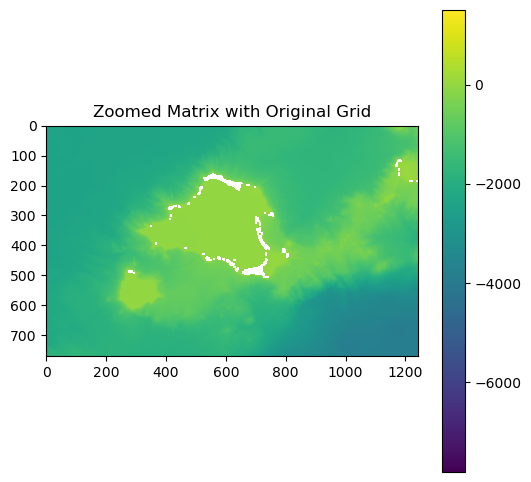

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Dimensions de la matrice
N, M = z2_combined.shape

# Facteur de zoom
zoom_factor = 10

# Dimensions de la région zoomée
zoomed_width = M // zoom_factor
zoomed_height = N // zoom_factor

# Indices du centre
center_x, center_y = N // 2, M // 2

# Calcul des indices de début et de fin pour le zoom
x_start = max(center_x - zoomed_height // 2, 0)
x_end = min(center_x + zoomed_height // 2, N)
y_start = max(center_y - zoomed_width // 2, 0)
y_end = min(center_y + zoomed_width // 2, M)

# Extraire les sous-matrices zoomées
matrix_zoom = z2_combined[x_start:x_end, y_start:y_end]

# Affichage de la matrice zoomée
plt.figure(figsize=(6, 6))
plt.title('Zoomed Matrix with Original Grid')

# Affichage de la matrice zoomée
plt.imshow(matrix_zoom, cmap='viridis', vmin=np.nanmin(z2_combined), vmax=np.nanmax(z2_combined))
plt.colorbar()

# Tracer les lignes verticales et horizontales espacées de 10 mailles
#spacing = 10  # Espacement des lignes de la grille

# Tracer des lignes verticales (tous les 10 pixels)
#for i in range(0, matrix_zoom.shape[1], spacing):  # Colonnes
#    plt.vlines(i - 0.5, ymin=-0.5, ymax=matrix_zoom.shape[0] - 0.5, color='white', linewidth=1.5)

# Tracer des lignes horizontales (tous les 10 pixels)
#for i in range(0, matrix_zoom.shape[0], spacing):  # Lignes
#    plt.hlines(i - 0.5, xmin=-0.5, xmax=matrix_zoom.shape[1] - 0.5, color='white', linewidth=1.5)


plt.show()


In [55]:
matrix_zoom.shape

(772, 1244)

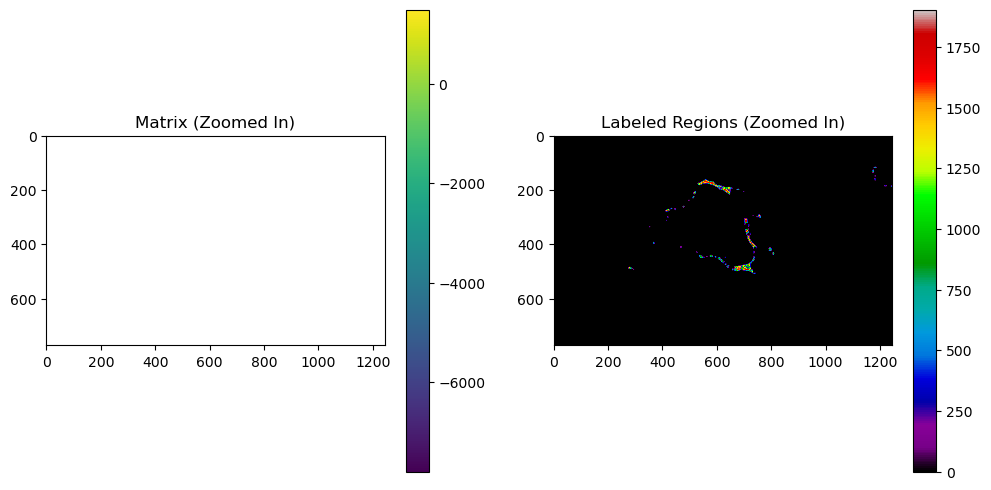

In [52]:
# Dimensions de la matrice
N, M = z2_combined_updated.shape

# Facteur de zoom
zoom_factor = 10

# Dimensions de la région zoomée
zoomed_width = M // zoom_factor
zoomed_height = N // zoom_factor

# Indices du centre
center_x, center_y = N // 2, M // 2

# Calcul des indices de début et de fin
x_start = max(center_x - zoomed_height // 2, 0)
x_end = min(center_x + zoomed_height // 2, N)
y_start = max(center_y - zoomed_width // 2, 0)
y_end = min(center_y + zoomed_width // 2, M)


# Extraire les sous-matrices
matrix_zoom = z2_combined[x_start:x_end, y_start:y_end]
labeled_zoom = labeled_array[x_start:x_end, y_start:y_end]

# Affichage des résultats
plt.figure(figsize=(12, 6))

# Matrice originale avec zoom
plt.subplot(1, 2, 1)
plt.title('Matrix (Zoomed In)')
plt.imshow(matrix_zoom, cmap='viridis', vmin=np.nanmin(z2_combined), vmax=np.nanmax(z2_combined))
plt.colorbar()



# Régions étiquetées avec zoom
plt.subplot(1, 2, 2)
plt.title('Labeled Regions (Zoomed In)')
plt.imshow(labeled_zoom, cmap='nipy_spectral')
plt.colorbar()

plt.show()


In [35]:
from scipy.spatial import KDTree

def interpolate_nearby(z2_combined, mask_nan, radius=5):
    # Trouver les coordonnées des points NaN
    coords_nan = np.array(np.nonzero(mask_nan)).T
    
    # Trouver les coordonnées des points non-NaN
    coords_non_nan = np.array(np.nonzero(~mask_nan)).T
    values_non_nan = z2_combined[~mask_nan]

    # Construire un KDTree pour trouver les voisins
    tree = KDTree(coords_non_nan)
    
    # Pour chaque point NaN, trouver les voisins dans un rayon donné
    z2_interpolated = np.copy(z2_combined)
    for coord in coords_nan:
        # Trouver les voisins dans le rayon spécifié
        dist, idx = tree.query(coord, k=radius)
        
        # Exclure les voisins trop éloignés (distances infinies ou trop grandes)
        valid_idx = idx[dist < radius]
        if len(valid_idx) > 1:  # At least two points needed for interpolation
            nearby_points = coords_non_nan[valid_idx]
            nearby_values = values_non_nan[valid_idx]
            
            # Interpoler les valeurs des voisins
            try:
                interpolated_value = griddata(nearby_points, nearby_values, [coord], method='linear', fill_value=np.nan)
                z2_interpolated[tuple(coord)] = interpolated_value
            except Exception as e:
                print(f"Interpolation error at point {coord}: {e}")
                z2_interpolated[tuple(coord)] = np.nan  # Set to NaN if interpolation fails
        else:
            z2_interpolated[tuple(coord)] = np.nan  # Not enough valid points for interpolation
    
    return z2_interpolated

#z2_combined_updated = interpolate_nearby(z2_combined, mask_interpolation, radius=5)

In [36]:
z2_combined_updated_2= z2_combined_updated.copy()
z2_combined_updated_2= interpolate_nearby(z2_combined_updated, mask_interpolation, radius=5)

Interpolation error at point [1669 7204]: QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate 1667

While executing:  | qhull d Qt Qbb Q12 Qc Qz
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1864268818  delaunay  Qtriangulate  Qbbound-last  Q12-allow-wide
  Qcoplanar-keep  Qz-infinity-point  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width  4  Error-roundoff 1e-11  _one-merge 7e-11
  Visible-distance 2e-11  U-max-coplanar 2e-11  Width-outside 4e-11
  _wide-facet 1.2e-10  _maxoutside 8e-11

Interpolation error at point [1669 7205]: QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate 1667

While executing:  | qhull d Qt Qbb Q12 Qc Qz
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1864268818  delaunay  Qtriangulate  Qbbound-last  Q12-allow-wide
  Qcoplanar-keep  Qz-infinity-point  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width  4  Error-rou

In [39]:
def interpolate_nearby(z2_combined, mask_nan, radius=5):
    # Trouver les coordonnées des points NaN
    coords_nan = np.array(np.nonzero(mask_nan)).T
    
    # Trouver les coordonnées des points non-NaN
    coords_non_nan = np.array(np.nonzero(~mask_nan)).T
    values_non_nan = z2_combined[~mask_nan]

    # Construire un KDTree pour trouver les voisins
    tree = KDTree(coords_non_nan)
    
    # Pour chaque point NaN, trouver les voisins dans un rayon donné
    z2_interpolated = np.copy(z2_combined)
    for coord in coords_nan:
        # Trouver les voisins dans le rayon spécifié
        dist, idx = tree.query(coord, k=radius)
        if len(idx) > 0:
            nearby_points = coords_non_nan[idx]
            nearby_values = values_non_nan[idx]
            
            # Assurer que les coordonnées sont distinctes
            if len(np.unique(nearby_points, axis=0)) >= 3:
                # Interpoler les valeurs des voisins
                interpolated_value = griddata(nearby_points, nearby_values, [coord], method='linear', fill_value=np.nan)
                z2_interpolated[tuple(coord)] = interpolated_value
            else:
                print(f"Coordonnée {coord} ne peut pas être interpolée en raison de points non distincts.")
    
    return z2_interpolated


In [41]:
import numpy as np
from scipy.spatial import KDTree
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import Rbf

def joggle_points(points, epsilon=1e-6):
    """Ajoute un léger décalage aux points pour éviter la colinéarité."""
    return points + np.random.uniform(-epsilon, epsilon, points.shape)

def interpolate_nearby(z2_combined, mask_nan, radius=5):
    """Interpoler les valeurs des points NaN en utilisant les voisins non-NaN."""
    # Trouver les coordonnées des points NaN
    coords_nan = np.array(np.nonzero(mask_nan)).T
    
    # Trouver les coordonnées des points non-NaN
    coords_non_nan = np.array(np.nonzero(~mask_nan)).T
    values_non_nan = z2_combined[~mask_nan]

    # Construire un KDTree pour trouver les voisins
    tree = KDTree(coords_non_nan)
    
    # Préparer le tableau de valeurs interpolées
    z2_interpolated = np.copy(z2_combined)

    for coord in coords_nan:
        # Trouver les voisins dans le rayon spécifié
        dist, idx = tree.query(coord, k=radius)
        if len(idx) > 0:
            nearby_points = coords_non_nan[idx]
            nearby_values = values_non_nan[idx]
            
            # Joggle les points pour éviter la colinéarité
            nearby_points_jiggled = joggle_points(nearby_points)
            
            try:
                # Créer un interpolateur avec les points ajustés
                interpolator = LinearNDInterpolator(nearby_points_jiggled, nearby_values, fill_value=np.nan)
                
                # Interpoler la valeur du point NaN
                interpolated_value = interpolator(coord)
                z2_interpolated[tuple(coord)] = interpolated_value
            except Exception as e:
                print(f"Erreur lors de l'interpolation au point {coord}: {e}")
                z2_interpolated[tuple(coord)] = np.nan
        else:
            print(f"Pas assez de voisins pour interpoler au point {coord}.")
    
    return z2_interpolated

In [ ]:
z2_combined_updated_2= z2_combined_updated.copy()
z2_combined_updated_2= interpolate_nearby(z2_combined_updated, mask_interpolation, radius=5)

In [22]:
# Définir les masques
mask_transition = mask_nan.astype(int) - mask_eroded.astype(int)  # Zone de transition
mask_highres = ~mask_nan  # Zone haute résolution
mask_lowres = mask_eroded  # Zone basse résolution

array([False, False, False, ..., False, False, False])

In [15]:
from scipy.ndimage import uniform_filter

# Appliquer une moyenne mobile sur la grille interpolée
window_size = buffer_width  # Taille de la fenêtre pour la moyenne mobile
z_smoothed = uniform_filter(z2_combined, size=window_size)

In [16]:
z2_combined-z_smoothed

array([[ -1.96666667,  -1.96666667,  -1.96666667, ..., -15.35277778,
        -14.43111111, -14.43111111],
       [ -1.96666667,  -1.96666667,  -1.96666667, ..., -15.35277778,
        -14.43111111, -14.43111111],
       [ -1.96666667,  -1.96666667,  -1.96666667, ..., -15.35277778,
        -14.43111111, -14.43111111],
       ...,
       [  4.75555556,   4.75555556,   4.75555556, ...,   3.61833333,
          3.28888889,   3.28888889],
       [  4.65111111,   4.65111111,   4.65111111, ...,   2.05555556,
          1.72222222,   1.72222222],
       [  4.65111111,   4.65111111,   4.65111111, ...,   2.05555556,
          1.72222222,   1.72222222]])

In [ ]:
from scipy.interpolate import SmoothBivariateSpline
#Aplatir les données
lat_flat = new_lat_grid_2.flatten()
lon_flat = new_lon_grid_2.flatten()
z2_combined_flat = z2_combined.flatten()
# Créer la spline de lissage avec SmoothBivariateSpline
spline = SmoothBivariateSpline(lat_flat, lon_flat, z2_combined_flat)

# Interpoler sur les nouvelles coordonnées
z2_smoothed = spline(new_lat_grid_2[:, 0], new_lon_grid_2[0, :])

In [30]:
len(new_lat_grid_2.flatten())

96357906

In [17]:
difference = z2_smoothed - z2_combined

In [18]:
np.nanmean(difference)

/tmp/ipykernel_280456/852989578.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(difference)


nan

In [25]:
np.isnan(z2_combined).sum()

0

In [88]:
print("Dimensions de new_lat_grid_2 :", new_lat_grid_2.shape)
print("Dimensions de new_lon_grid_2 :", new_lon_grid_2.shape)
print("Dimensions de z2_combined :", z2_combined.shape)
print("Nombre de NaN dans z2_combined :", np.isnan(z2_combined).sum())
print("Plage des latitudes :", new_lat_grid_2[:, 0].min(), "à", new_lat_grid_2[:, 0].max())
print("Plage des longitudes :", new_lon_grid_2[0, :].min(), "à", new_lon_grid_2[0, :].max())


Dimensions de new_lat_grid_2 : (7734, 12459)
Dimensions de new_lon_grid_2 : (7734, 12459)
Dimensions de z2_combined : (7734, 12459)
Nombre de NaN dans z2_combined : 0
Plage des latitudes : -24.379167700534758 à -16.646167700525307
Plage des longitudes : 160.25416666778074 à 172.71216666784022


In [87]:
len(z2_smoothed[mask_nan])

1779524

In [28]:
z2_interp[mask_nan]= z2_smoothed[mask_nan]

In [16]:
# Masque de la limite extérieure de la zone tampon (partie grille 2)
#lon_buffer_min_ext = lon_buffer_min - 30*resolution_lon
#lon_buffer_max_ext = lon_buffer_max + 30*resolution_lon
#lat_buffer_min_ext = lat_buffer_min - 30*resolution_lat
#lat_buffer_max_ext = lat_buffer_max + 30*resolution_lat

#Masque: zone tampon + grille haute résolution
#mask_buff_ext_extremum=(new_lon_grid_2 >= lon_buffer_min_ext) & (new_lon_grid_2 <= lon_buffer_max_ext) & \
#                   (new_lat_grid_2 >= lat_buffer_min_ext) & (new_lat_grid_2 <= lat_buffer_max_ext)

#mask_buff_ext= mask_buff_ext_extremum & ~mask_buff_extremum

IndentationError: unexpected indent (1040564234.py, line 9)

In [29]:
import numpy as np
from scipy.ndimage import binary_dilation

# Appliquer une dilatation binaire pour obtenir les voisins externes
dilated_mask_buffer_ext = binary_dilation(mask_buff_extremum)

# Les bords externes sont ceux qui sont dans la dilatation mais pas dans le masque initial
border_buffer_ext = dilated_mask_buffer_ext & ~mask_buff_extremum

# Récupérer les indices des bords extérieurs
#indices_border_buff_ext = np.where(border_buffer_ext)

In [18]:
# Masque de la limite intérieure de la zone tampon (partie grille 1)
#lon_buffer_min_int = lon_min + 3*resolution_lon
#lon_buffer_max_int = lon_max - 3*resolution_lon
#lat_buffer_min_int = lat_min + 3*resolution_lat
#lat_buffer_max_int = lat_max - 3*resolution_lat

#Masque: zone tampon + grille haute résolution
#mask_buff_int_extremum=(new_lon_grid_2 >= lon_buffer_min_int) & (new_lon_grid_2 <= lon_buffer_max_int) & \
  #                 (new_lat_grid_2 >= lat_buffer_min_int) & (new_lat_grid_2 <= lat_buffer_max_int)

#mask_buff_int= ~mask_buff_int_extremum & mask_overlap

In [30]:
from scipy.ndimage import binary_erosion
#Appliquer une érosion binaire pour identifier l'intérieur
eroded_mask = binary_erosion(mask_overlap)

# Les bords intérieurs sont ceux qui sont dans le masque initial mais pas dans l'érosion
border_mask_inner = mask_overlap & ~eroded_mask


# Récupérer les indices des bords intérieurs
#indices_border_inner = np.where(border_mask_inner)

In [20]:
# Coordonnées et valeurs pour la zone tampon
#lon_buffer = new_lon_grid_2[mask_buffer]
#lat_buffer = new_lat_grid_2[mask_buffer]

# Coordonnées et valeurs pour la grille 1 utiles
#lon_buffer_int = new_lon_grid_2[mask_buff_int]
#lat_buffer_int = new_lat_grid_2[mask_buff_int]

# Coordonnées et valeurs pour la grille 2 utiles
#lon_buffer_ext = new_lon_grid_2[mask_buff_ext]
#lat_buffer_ext = new_lat_grid_2[mask_buff_ext]

In [21]:
# Coordonnées des points dans la zone tampon
#coords_buffer = np.vstack((lon_buffer, lat_buffer)).T

# Coordonnées des points dans la grille 1 utiles
#coords_buffer_int = np.vstack((lon_buffer_int, lat_buffer_int)).T

# Coordonnées des points dans la grille 1 utiles
#coords_buffer_ext = np.vstack((lon_buffer_ext, lat_buffer_ext)).T

In [22]:
#from scipy.spatial import cKDTree

# Coordonnées des points de la grille haute résolution
#coords_high_res = np.vstack((new_lon_grid_2[mask_overlap].ravel(), new_lat_grid_2[mask_overlap].ravel())).T

# Créer un arbre KD pour les points de la grille haute résolution
#tree_high_res = cKDTree(coords_buffer_int)

In [23]:
# Créer un arbre KD pour les points de la grille basse résolution
#tree_low_res = cKDTree(coords_buffer_ext)

In [24]:
# Trouver les indices des points les plus proches et les distances
#distances_to_high_res, indices_high_res = tree_high_res.query(coords_buffer)
# Trouver les distances aux points les plus proches de la grille 2 (hors de la zone tampon)
#distances_to_low_res, indices_low_res = tree_low_res.query(coords_buffer)

In [31]:
# Rayon approximatif de la Terre en mètres
#R = 6371000  # Rayon moyen de la Terre en mètres

# Fonction pour calculer la distance de Haversine
#def haversine(lon1, lat1, lon2, lat2):
#    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
#    dlon = lon2 - lon1
#    dlat = lat2 - lat1
#    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
#    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
#    return R * c

lon_inner = new_lon_grid_2[border_mask_inner]
lat_inner = new_lat_grid_2[border_mask_inner]
lon_outer = new_lon_grid_2[border_buffer_ext]
lat_outer = new_lat_grid_2[border_buffer_ext]

# Extraire les valeurs de z2_interp aux bords intérieurs et extérieurs
values_inner = z2_interp[border_mask_inner]
values_outer = z2_interp[border_buffer_ext]

# Pour chaque maille dans mask_buffer, trouver les valeurs à partir des bords intérieurs et extérieurs les plus proches
buffer_lon = new_lon_grid_2[mask_buffer]
buffer_lat = new_lat_grid_2[mask_buffer]

# Initialiser les tableaux pour stocker les valeurs interpolées
interpolated_values = np.zeros(buffer_lon.shape)

# Pour chaque maille dans mask_buffer
for i, (lon, lat) in enumerate(zip(buffer_lon, buffer_lat)):
    # Calculer les distances à toutes les mailles de border_mask_inner et border_mask_ext
    #dist_inner = haversine(lon, lat, lon_inner, lat_inner)
    #dist_outer = haversine(lon, lat, lon_outer, lat_outer)
    dist_inner = np.sqrt((lon_inner - lon)**2 + (lat_inner - lat)**2)
    dist_outer = np.sqrt((lon_outer - lon)**2 + (lat_outer - lat)**2)
    
    
    # Trouver les indices des bords les plus proches
    nearest_inner_idx = np.argmin(dist_inner)
    nearest_outer_idx = np.argmin(dist_outer)
    
    # Extraire les valeurs les plus proches
    value_inner = values_inner[nearest_inner_idx]
    value_outer = values_outer[nearest_outer_idx]
    
    # Calculer la distance totale pour la pondération
    total_distance = dist_inner[nearest_inner_idx] + dist_outer[nearest_outer_idx]
    
    # Calculer les poids pour l'interpolation
    weight_inner = dist_outer[nearest_outer_idx] / total_distance
    weight_outer = dist_inner[nearest_inner_idx] / total_distance
    
    # Calculer la valeur interpolée
    interpolated_values[i] = weight_inner * value_inner + weight_outer * value_outer


z2_interp[mask_buffer] = interpolated_values

In [28]:
# Éviter les divisions par zéro (si un point est très proche d'un autre point)
#epsilon = 1e-10
#distances_to_high_res = distances_to_high_res + epsilon
#distances_to_low_res = distances_to_low_res + epsilon

# Calculer les pondérations inverses aux distances
#weights_high_res = 1 / distances_to_high_res
#weights_low_res = 1 / distances_to_low_res

# Normaliser les pondérations pour que leur somme soit égale à 1
#weights_sum = weights_high_res + weights_low_res
#weights_high_res /= weights_sum
#weights_low_res /= weights_sum

#weights_high_res = 1 - (distances_to_high_res / (distances_to_high_res + distances_to_low_res))
#weights_low_res = 1 - weights_high_res

In [29]:
# Extraire les valeurs interpolées des deux grilles
#z_high_res_nearest = z2_interp[mask_buff_int][indices_high_res]
#z_low_res_nearest = z2_interp[mask_buff_ext][indices_low_res]

In [30]:
# Calculer la valeur lissée pour chaque point dans la zone tampon
#z_smooth = weights_high_res * z_high_res_nearest + weights_low_res * z_low_res_nearest
#z_smooth = (weights_high_res * z_high_res_nearest + weights_low_res * z_low_res_nearest + z2_interp[mask_buffer]) / 2


In [ ]:
# Remplacer les valeurs dans la zone tampon
#z2_interp[mask_buffer] = z_smooth

In [ ]:
#import scipy.ndimage as ndimage
#mask_nan = np.isnan(z2_interp)
#z2_interp[mask_nan] = z2_save[mask_nan]
# Appliquer un filtre de lissage (gaussien) sur la zone des trous comblés
# sigma contrôle l'intensité du lissage (ajuster en fonction des résultats)
#z_smooth_nan = ndimage.gaussian_filter(z2_save, sigma=3)
#z2_interp[mask_nan] = z_smooth_nan[mask_nan]

In [32]:
import xarray as xr

# Obtenez les coordonnées uniques
new_lon_unique = np.unique(new_lon_grid_2)
new_lat_unique = np.unique(new_lat_grid_2)

# Créer un DataArray pour les données interpolées
ds_interpolated = xr.DataArray(
    z2_interp, 
    coords=[('lat', new_lat_unique), ('lon', new_lon_unique)],  # Ajouter les coordonnées
    dims=['lat', 'lon']  # Spécifier les dimensions
)

# Créer un Dataset pour organiser les variables
ds_to_save = xr.Dataset({
    'z2_interp': ds_interpolated  # Ajouter la variable interpolée
})

# Sauvegarder dans un fichier NetCDF
ds_to_save.to_netcdf('composite_etopo_jroger.nc')


In [37]:
#z2_save= z2_interp.copy()

# 3. Remplacer les données de z2_interp uniquement dans la zone de chevauchement avec celles de la grille 1
#z2_save[mask_overlap] = z1_interp_on_z2_overlap

# Créer un DataArray pour les données interpolées
ds_raw_merge= xr.DataArray(
    z2_save, 
    coords=[('lat', new_lat_unique), ('lon', new_lon_unique)],  # Ajouter les coordonnées
    dims=['lat', 'lon']  # Spécifier les dimensions
)

# Créer un Dataset pour organiser les variables
ds_to_save_bis = xr.Dataset({
    'z2_interp': ds_raw_merge  # Ajouter la variable interpolée
})

# Sauvegarder dans un fichier NetCDF
ds_to_save_bis.to_netcdf('composite_etopo_jroger_no_smooth.nc')


In [46]:
# Reshape interpolated values to match the original 2D shape of the mask overlap
nrows, ncols = mask_overlap.shape
z1_interp_on_z2_overlap_reshaped = z1_interp_on_z2_overlap.reshape(nrows, ncols)

ValueError: cannot reshape array of size 50922000 into shape (7734,12459)

In [48]:
# Créer un scatter plot des valeurs interpolées sur la zone de chevauchement
plt.figure(figsize=(8, 6))
plt.scatter(new_lon_grid_2[mask_overlap], new_lat_grid_2[mask_overlap], c=z1_interp_on_z2_overlap, cmap='viridis', s=1)
plt.colorbar(label='Interpolated Values')
plt.title('Interpolated Grid 1 Data on Overlapping Region with Grid 2')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


KeyboardInterrupt: 

In [50]:
np.isnan(z1_interp_on_z2_overlap).sum()

1779524

In [51]:
np.isnan(z_flat_1).sum()

1779911

In [54]:
mask_nan.sum()

1779524

In [47]:
7734*12459

96357906

In [57]:
z1_interp_on_z2_overlap

array([-1218.75891113, -1218.80944824, -1218.88671875, ...,
       -2718.42919922, -2719.58203125, -2720.7421875 ])

In [61]:
z2_save-z2_smoothed

array([[ 6.82121026e-13,  4.54747351e-13,  9.09494702e-13, ...,
         0.00000000e+00,  9.09494702e-13,  9.09494702e-13],
       [ 2.27373675e-13,  2.27373675e-13,  2.27373675e-13, ...,
         2.72848411e-12,  9.09494702e-13,  9.09494702e-13],
       [ 2.27373675e-13,  2.27373675e-13,  2.27373675e-13, ...,
         0.00000000e+00,  0.00000000e+00, -9.09494702e-13],
       ...,
       [ 1.81898940e-12,  1.81898940e-12,  9.09494702e-13, ...,
         4.54747351e-13,  9.09494702e-13,  4.54747351e-13],
       [ 1.81898940e-12,  1.81898940e-12,  0.00000000e+00, ...,
         1.36424205e-12,  4.54747351e-13,  4.54747351e-13],
       [ 9.09494702e-13,  9.09494702e-13,  0.00000000e+00, ...,
         9.09494702e-13,  0.00000000e+00,  0.00000000e+00]])

In [62]:
spline

In [63]:
mask_overlap.shape

(7734, 12459)

In [65]:
len(z1_interp_on_z2_overlap)*2

101844000

In [66]:
(new_lon_grid_2[mask_overlap], new_lat_grid_2[mask_overlap]).shape

AttributeError: 'tuple' object has no attribute 'shape'

In [67]:
new_lat_grid_2[mask_overlap].shape

(50922000,)

In [68]:
new_lon_grid_2[mask_overlap].shape

(50922000,)